### This notebook shows how to 

In [143]:
import os
from fabrictestbed.slice_manager import SliceManager, Status
import json

In [144]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"CM Host: {credmgr_host} Orchestrator Host: {orchestrator_host}")

CM Host: cm.fabric-testbed.net Orchestrator Host: orchestrator.fabric-testbed.net


## Create Slice Manager Object
Users can request tokens with different Project and Scopes by altering `project_name` and `scope` parameters in the refresh call below.

In [145]:
slice_manager = SliceManager(oc_host=orchestrator_host, cm_host=credmgr_host, project_name='all', scope='all')

# Initialize the slice manager
slice_manager.initialize()

### Orchestrator API example to query for available resources

In [147]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: NCSA: { cpu: 6/6 , core: 160/192 , ram: 1,416/1,536 G, disk: 60,188/60,600 G, unit: 3/3 }
	Components:
		NVME-P4510:  NVME P4510 { disk: 8,640/9,600 G, unit: 9/10 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 2/2 }
		GPU-RTX6000:  GPU RTX6000 { unit: 3/3 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 1/2 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 1/2 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 376/381 }
	Site Interfaces:
		NCSA_STAR: TrunkPort { bw: 100/100 Gbps}
TACC: { cpu: 10/10 , core: 266/320 , ram: 2,248/2,560 G, disk: 114,620/116,400 G, unit: 5/5 }
	Components:
		GPU-RTX6000:  GPU RTX6000 { unit: 6/6 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 15,360/15,360 G, unit: 16/16 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 614/635 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 3/4 }
	Site Interfaces:
		TACC_UTAH: TrunkPort { 

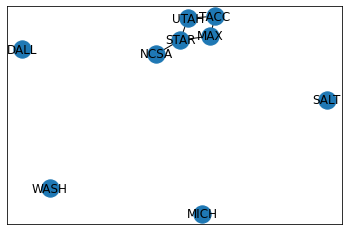

In [148]:
if status == Status.OK:
    advertised_topology.draw()

## Create Slice

We will request two nodes. We will attach a smart NIC to one of them, and a shared NIC to the other. Configurations for the NICs are going to be different.

The setup is shown below:

In [149]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType
# Create topology
t = ExperimentTopology()

# Add node
n1 = t.add_node(name='n1', site='MAX')

# Set capacities
cap = Capacities()
cap.set_fields(core=2, ram=6, disk=10)

# Set Properties
n1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')

# Add PCI devices
n1.add_component(ctype=ComponentType.NVME, model='P4510', name='c1')

# Add node
n2 = t.add_node(name='n2', site='NCSA')

# Set properties
n2.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')

# Add node
n3 = t.add_node(name='n3', site='UTAH')

# Set properties
n3.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')


n1.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name='n1-nic1')
n2.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name='n2-nic1')
n3.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_5, name='n3-nic1')


if_labels = n1.interface_list[0].get_property(pname="labels")
if_labels.vlan = "200"
n1.interface_list[0].set_properties(labels=if_labels)
if_labels = n2.interface_list[0].get_property(pname="labels")
if_labels.vlan = "200"
n2.interface_list[0].set_properties(labels=if_labels)

# L2PTP Service
t.add_network_service(name='ptp1', nstype=ServiceType.L2PTP,
                      interfaces=[n1.interface_list[0], n2.interface_list[0]])


if_labels = n1.interface_list[1].get_property(pname="labels")
if_labels.vlan = "200"
n2.interface_list[1].set_properties(labels=if_labels)
if_labels = n2.interface_list[0].get_property(pname="labels")
if_labels.vlan = "200"
n3.interface_list[0].set_properties(labels=if_labels)

# L2PTP Service
t.add_network_service(name='ptp2', nstype=ServiceType.L2PTP,
                      interfaces=[n2.interface_list[1], n3.interface_list[0]])

# Generate Slice Graph
slice_graph = t.serialize()

# print(interfaces_tuple)

ssh_key = None
with open ("/home/fabric/.ssh/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read()
    ssh_key=ssh_key.strip()

# Request slice from Orchestrator
status, reservations = slice_manager.create(slice_name='Slice-l2bridge-ded-multiple-tags', slice_graph=slice_graph, ssh_key=ssh_key)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Reservations created {}".format(reservations))
else:
    print(f"Failure: {reservations}")

Response Status Status.OK
Reservations created [{
    "graph_node_id": "2ef83f7a-f77c-49e6-944e-9c6cf786d7c3",
    "lease_end": "2021-12-09 07:02:57",
    "pending_state": "None_",
    "reservation_id": "bebd3e14-c055-4ab5-b17c-1f9f74a0d672",
    "reservation_state": "Unknown",
    "slice_id": "126f426c-4e8d-4b98-b39d-470f58043c01"
}, {
    "graph_node_id": "254cb5c3-f438-4f82-be2e-54296ca67246",
    "lease_end": "2021-12-09 07:02:57",
    "pending_state": "None_",
    "reservation_id": "067a40a9-095a-4bfd-a0e2-d764aca24bd9",
    "reservation_state": "Unknown",
    "slice_id": "126f426c-4e8d-4b98-b39d-470f58043c01"
}, {
    "graph_node_id": "c9a28049-ff8c-4e13-8c5b-ccd1ba12488f",
    "lease_end": "2021-12-09 07:02:57",
    "pending_state": "None_",
    "reservation_id": "79fa65cf-6d26-47c0-b0fe-f26eb6375cf5",
    "reservation_state": "Unknown",
    "slice_id": "126f426c-4e8d-4b98-b39d-470f58043c01"
}, {
    "graph_node_id": "01ece77d-2d9e-46fd-b2d4-23ccea0a70d2",
    "lease_end": "2021

In [150]:
# Set the Slice ID from output of the above command
slice_id=reservations[0].slice_id

## Query Slices

In [158]:
status, slices = slice_manager.slices() #(state="All")

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slices {}".format(slices))
else:
    print(f"Failure: {slices}")

Response Status Status.OK
Slices [{
    "graph_id": "f1d68ad0-48ae-4f09-a051-369caed22446",
    "lease_end": "2021-11-21 01:22:55",
    "slice_id": "8ef39ae0-9ccd-40e8-992a-2497b01f5341",
    "slice_name": "Slice-Kubernetes-Hello-World",
    "slice_state": "Dead"
}, {
    "graph_id": "44625d85-ad4a-4c80-bb27-c3f810735c06",
    "lease_end": "2021-11-17 07:00:32",
    "slice_id": "7bb8c733-e0f8-4a0b-abaf-4b433ab66167",
    "slice_name": "Slice-Kubernetes-Hello-World",
    "slice_state": "Dead"
}, {
    "graph_id": "a161a769-0f89-43b0-bfe2-396c256baa25",
    "lease_end": "2021-11-22 19:23:09",
    "slice_id": "b4f605c8-6974-482d-a7fb-c0c6c3109108",
    "slice_name": "Slice-Kubernetes-Hello-World",
    "slice_state": "Dead"
}, {
    "graph_id": "df6b2c6f-e371-442b-a1f5-d18df4534e1d",
    "lease_end": "2021-12-01 05:03:24",
    "slice_id": "274f8cf0-976a-4d12-bf1d-44af0add4173",
    "slice_name": "Slice-l2bridge-ded-multiple-tags",
    "slice_state": "Closing"
}, {
    "graph_id": "90fa6b2a

## Query Slivers

In [159]:
slice_object = list(filter(lambda x: x.slice_id == slice_id, slices))[0]
status, slivers = slice_manager.slivers(slice_object=slice_object)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slivers {}".format(slivers))
else:
    print(f"Failure: {slivers}")

Response Status Status.OK
Slivers [{
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-0000080a\", \"instance_parent\": \"max-w3.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 6}",
    "capacity_hints": "{\"instance_type\": \"fabric.c2.m8.d10\"}",
    "graph_node_id": "2ef83f7a-f77c-49e6-944e-9c6cf786d7c3",
    "join_state": "NoJoin",
    "lease_end": "2021-12-09 07:02:57",
    "management_ip": "63.239.135.69",
    "name": "n1",
    "notices": "Reservation bebd3e14-c055-4ab5-b17c-1f9f74a0d672 (Slice Slice-l2bridge-ded-multiple-tags(126f426c-4e8d-4b98-b39d-470f58043c01) Graph Id:9757b2b5-907c-48da-914e-4cd4ed63c9c2 Owner:name: orchestrator guid: orchestrator-guid email: minawm@bu.edu State:StableOK ) is in state [Active,None_]\n\nLast ticket update: \nTicket events: \nLast ticket update: \nTicket events: ",
    "pending_state": "None_",
    "reservation_id": "bebd3e14-c055-4ab5-b17c-

### Now let's connect to the nodes with paramiko.

In [160]:
import paramiko

In [161]:
client1_ip = list(filter(lambda sliver : sliver.name == "n1",slivers))[0].management_ip
client1_ip

'63.239.135.69'

In [162]:
client2_ip = list(filter(lambda sliver : sliver.name == "n2",slivers))[0].management_ip
client2_ip

'141.142.140.23'

In [163]:
client3_ip = list(filter(lambda sliver : sliver.name == "n3",slivers))[0].management_ip
client3_ip

'2001:1948:417:7:f816:3eff:fe88:2680'

In [164]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
client1 = paramiko.SSHClient()
client1.load_system_host_keys()
client1.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client1.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client1.connect(client1_ip,username='ubuntu',pkey = key)

client1

In [165]:
stdin, stdout, stderr = client1.exec_command('lsb_release -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.3 LTS
Release:	20.04
Codename:	focal

No LSB modules are available.



In [166]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
client2 = paramiko.SSHClient()
client2.load_system_host_keys()
client2.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client2.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client2.connect(client2_ip,username='ubuntu',pkey = key)

client2

In [167]:
stdin, stdout, stderr = client2.exec_command('lsb_release -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.3 LTS
Release:	20.04
Codename:	focal

No LSB modules are available.



In [168]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")

bastion_public_addr = 'bastion-1.fabric-testbed.net'
bastion_private_ipv4_addr = '192.168.11.226'
bastion_private_ipv6_addr = '2600:2701:5000:a902::c'

bastion_username = 'minawm_0041350787'

bastion_key_filename = os.environ['HOME'] + "/work/mina_bastion_key"

jump = paramiko.SSHClient()
jump.set_missing_host_key_policy(paramiko.AutoAddPolicy())
bastion_pkey = paramiko.RSAKey.from_private_key_file(bastion_key_filename)
jump.connect(bastion_public_addr, username=bastion_username, pkey=bastion_pkey)

jump_transport = jump.get_transport()
src_addr = (bastion_private_ipv4_addr, 22)
dest_addr = (client3_ip, 22)
jump_channel = jump_transport.open_channel("direct-tcpip", dest_addr, src_addr)

client3=paramiko.SSHClient()
client3.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client3.connect(client3_ip, username='ubuntu', pkey=key, sock=jump_channel) #key_filename=ssh_key_filename

client3

In [169]:
stdin, stdout, stderr = client3.exec_command('lsb_release -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.3 LTS
Release:	20.04
Codename:	focal

No LSB modules are available.



### Let's try to let the nodes ping each other through their management IPs.

In [175]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 ' + client2_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 141.142.140.23 (141.142.140.23) 56(84) bytes of data.
64 bytes from 141.142.140.23: icmp_seq=1 ttl=52 time=18.0 ms
64 bytes from 141.142.140.23: icmp_seq=2 ttl=52 time=18.0 ms
64 bytes from 141.142.140.23: icmp_seq=3 ttl=52 time=18.0 ms
64 bytes from 141.142.140.23: icmp_seq=4 ttl=52 time=18.0 ms
64 bytes from 141.142.140.23: icmp_seq=5 ttl=52 time=18.1 ms

--- 141.142.140.23 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4006ms
rtt min/avg/max/mdev = 17.957/17.995/18.103/0.053 ms




In [176]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 ' + client3_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))


ping: connect: Network is unreachable



In [177]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 ' + client1_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 63.239.135.69 (63.239.135.69) 56(84) bytes of data.
64 bytes from 63.239.135.69: icmp_seq=1 ttl=53 time=18.1 ms
64 bytes from 63.239.135.69: icmp_seq=2 ttl=53 time=18.0 ms
64 bytes from 63.239.135.69: icmp_seq=3 ttl=53 time=17.9 ms
64 bytes from 63.239.135.69: icmp_seq=4 ttl=53 time=18.0 ms
64 bytes from 63.239.135.69: icmp_seq=5 ttl=53 time=18.0 ms

--- 63.239.135.69 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4006ms
rtt min/avg/max/mdev = 17.934/18.000/18.110/0.060 ms




In [178]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 ' + client3_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))


ping: connect: Network is unreachable



In [179]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 ' + client1_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 63.239.135.69 (63.239.135.69) 56(84) bytes of data.
From 10.20.4.108 icmp_seq=1 Destination Host Unreachable
From 10.20.4.108 icmp_seq=2 Destination Host Unreachable
From 10.20.4.108 icmp_seq=3 Destination Host Unreachable
From 10.20.4.108 icmp_seq=4 Destination Host Unreachable
From 10.20.4.108 icmp_seq=5 Destination Host Unreachable

--- 63.239.135.69 ping statistics ---
5 packets transmitted, 0 received, +5 errors, 100% packet loss, time 4098ms
pipe 3




In [180]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 ' + client2_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 141.142.140.23 (141.142.140.23) 56(84) bytes of data.
From 10.20.4.108 icmp_seq=1 Destination Host Unreachable
From 10.20.4.108 icmp_seq=2 Destination Host Unreachable
From 10.20.4.108 icmp_seq=3 Destination Host Unreachable
From 10.20.4.108 icmp_seq=4 Destination Host Unreachable
From 10.20.4.108 icmp_seq=5 Destination Host Unreachable

--- 141.142.140.23 ping statistics ---
5 packets transmitted, 0 received, +5 errors, 100% packet loss, time 4099ms
pipe 3




### To begin with, we will need to use the `route` command. So we need to install `net-tools`.

In [181]:
stdin, stdout, stderr = client1.exec_command('sudo apt update && sudo apt install -y net-tools traceroute iperf3')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))
stdin, stdout, stderr = client2.exec_command('sudo apt update && sudo apt install -y net-tools traceroute iperf3')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))
stdin, stdout, stderr = client3.exec_command('sudo apt update && sudo apt install -y net-tools traceroute iperf3')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Hit:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:5 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:6 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:7 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://nova.clouds.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://nova.clouds.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://nova.clouds.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [1389 kB]
Get:12 http://nova.clouds.archiv

### Let's look at the available interfaces.

In [182]:
stdin, stdout, stderr = client1.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:52:50:08 brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.42/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 85753sec preferred_lft 85753sec
    inet6 fe80::f816:3eff:fe52:5008/64 scope link 
       valid_lft forever preferred_lft forever
3: ens8: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 04:3f:72:fe:a6:70 brd ff:ff:ff:ff:ff:ff
4: ens9: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 04:3f:72:fe:a6:71 brd ff:ff:ff:ff:ff:ff




In [183]:
stdin, stdout, stderr = client2.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:26:b4:62 brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.228/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 86110sec preferred_lft 86110sec
    inet6 fe80::f816:3eff:fe26:b462/64 scope link 
       valid_lft forever preferred_lft forever
3: ens7: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether b8:ce:f6:37:76:0a brd ff:ff:ff:ff:ff:ff
4: ens8: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether b8:ce:f6:37:76:0b brd ff:ff:ff:ff:ff:ff




In [184]:
stdin, stdout, stderr = client3.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:88:26:80 brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.108/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 85863sec preferred_lft 85863sec
    inet6 2001:1948:417:7:f816:3eff:fe88:2680/64 scope global dynamic mngtmpaddr noprefixroute 
       valid_lft 86357sec preferred_lft 14357sec
    inet6 fe80::f816:3eff:fe88:2680/64 scope link 
       valid_lft forever preferred_lft forever
3: ens7: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 04:3f:72:fa:75:88 brd ff:ff:ff:ff:ff:ff
4: ens8: <BROADCAST,MULTICAST> mtu 15

### All nodes have two network interfaces.

### Now, we need to remember that we have requested that

- `n1`'s first port (`ens8`) and `n2`'s first port (`ens7`) are in the same vlan which is tagged `200`
- `n2`'s second port (`ens8`) and `n3`'s first port (`ens7`) are in the same vlan which is tagged `201`

<hr>

### Now let's configure our interfaces.

### Let's begin by configuring `n1`'s NIC.

In [186]:
stdin, stdout, stderr = client1.exec_command('sudo ip link add link ens8 name ens8.200 type vlan id 200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [188]:
stdin, stdout, stderr = client1.exec_command('sudo ip link set dev ens8 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [189]:
stdin, stdout, stderr = client1.exec_command('sudo ip link set dev ens8.200 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [190]:
stdin, stdout, stderr = client1.exec_command('sudo ip addr add 192.168.10.51/24 dev ens8.200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [191]:
stdin, stdout, stderr = client1.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:52:50:08 brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.42/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 85694sec preferred_lft 85694sec
    inet6 fe80::f816:3eff:fe52:5008/64 scope link 
       valid_lft forever preferred_lft forever
3: ens8: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP group default qlen 1000
    link/ether 04:3f:72:fe:a6:70 brd ff:ff:ff:ff:ff:ff
    inet6 fe80::63f:72ff:fefe:a670/64 scope link 
       valid_lft forever preferred_lft forever
4: ens9: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default ql

<hr>

### Now let's configure `n2`'s NIC.

<!-- ### We need to add a new interface that picks traffic tagged `200` (as we specified when we were creating the slice).

### We are going to create two "vlan" interfaces called `ens7.200` and `ens8.200`. They are going to pick traffic tagged `200` from their corresponding interfaces (`ens7` and `ens8` respectively).

### And then we will assign IP addresses to `ens7.200` and `ens8.200`. -->

In [192]:
stdin, stdout, stderr = client2.exec_command('sudo ip link add link ens7 name ens7.200 type vlan id 200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [193]:
stdin, stdout, stderr = client2.exec_command('sudo ip link set dev ens7 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [194]:
stdin, stdout, stderr = client2.exec_command('sudo ip link set dev ens7.200 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [195]:
stdin, stdout, stderr = client2.exec_command('sudo ip addr add 192.168.10.52/24 dev ens7.200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [196]:
stdin, stdout, stderr = client2.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:26:b4:62 brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.228/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 86026sec preferred_lft 86026sec
    inet6 fe80::f816:3eff:fe26:b462/64 scope link 
       valid_lft forever preferred_lft forever
3: ens7: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP group default qlen 1000
    link/ether b8:ce:f6:37:76:0a brd ff:ff:ff:ff:ff:ff
    inet6 fe80::bace:f6ff:fe37:760a/64 scope link 
       valid_lft forever preferred_lft forever
4: ens8: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default 

<hr>

In [197]:
stdin, stdout, stderr = client2.exec_command('sudo ip link add link ens8 name ens8.200 type vlan id 200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [198]:
stdin, stdout, stderr = client2.exec_command('sudo ip link set dev ens8 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [199]:
stdin, stdout, stderr = client2.exec_command('sudo ip link set dev ens8.200 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [200]:
stdin, stdout, stderr = client2.exec_command('sudo ip addr add 192.168.20.52/24 dev ens8.200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [201]:
stdin, stdout, stderr = client2.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:26:b4:62 brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.228/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 86001sec preferred_lft 86001sec
    inet6 fe80::f816:3eff:fe26:b462/64 scope link 
       valid_lft forever preferred_lft forever
3: ens7: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP group default qlen 1000
    link/ether b8:ce:f6:37:76:0a brd ff:ff:ff:ff:ff:ff
    inet6 fe80::bace:f6ff:fe37:760a/64 scope link 
       valid_lft forever preferred_lft forever
4: ens8: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP group 

<hr>

### And finally, let's configure `n3`'s NICs.

In [202]:
stdin, stdout, stderr = client3.exec_command('sudo ip link add link ens7 name ens7.200 type vlan id 200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [203]:
stdin, stdout, stderr = client3.exec_command('sudo ip link set dev ens7 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [204]:
stdin, stdout, stderr = client3.exec_command('sudo ip link set dev ens7.200 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [205]:
stdin, stdout, stderr = client3.exec_command('sudo ip addr add 192.168.20.53/24 dev ens7.200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [206]:
stdin, stdout, stderr = client3.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:88:26:80 brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.108/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 85742sec preferred_lft 85742sec
    inet6 2001:1948:417:7:f816:3eff:fe88:2680/64 scope global dynamic mngtmpaddr noprefixroute 
       valid_lft 86321sec preferred_lft 14321sec
    inet6 fe80::f816:3eff:fe88:2680/64 scope link 
       valid_lft forever preferred_lft forever
3: ens7: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP group default qlen 1000
    link/ether 04:3f:72:fa:75:88 brd ff:ff:ff:ff:ff:ff
    inet6 fe80::63f:72ff:fefa

<hr>

### Now let's ping

In [226]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.52 (192.168.10.52) 56(84) bytes of data.
64 bytes from 192.168.10.52: icmp_seq=1 ttl=64 time=35.6 ms
64 bytes from 192.168.10.52: icmp_seq=2 ttl=64 time=17.5 ms
64 bytes from 192.168.10.52: icmp_seq=3 ttl=64 time=17.6 ms
64 bytes from 192.168.10.52: icmp_seq=4 ttl=64 time=17.6 ms
64 bytes from 192.168.10.52: icmp_seq=5 ttl=64 time=17.6 ms

--- 192.168.10.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4007ms
rtt min/avg/max/mdev = 17.535/21.167/35.612/7.222 ms




In [227]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.20.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.52 (192.168.20.52) 56(84) bytes of data.

--- 192.168.20.52 ping statistics ---
5 packets transmitted, 0 received, 100% packet loss, time 4094ms





In [228]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.20.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.53 (192.168.20.53) 56(84) bytes of data.

--- 192.168.20.53 ping statistics ---
5 packets transmitted, 0 received, 100% packet loss, time 4104ms





### We can see above that client1 is able to talk to client2's first port only.

In [229]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.51 (192.168.10.51) 56(84) bytes of data.
64 bytes from 192.168.10.51: icmp_seq=1 ttl=64 time=17.6 ms
64 bytes from 192.168.10.51: icmp_seq=2 ttl=64 time=17.5 ms
64 bytes from 192.168.10.51: icmp_seq=3 ttl=64 time=17.6 ms
64 bytes from 192.168.10.51: icmp_seq=4 ttl=64 time=17.6 ms
64 bytes from 192.168.10.51: icmp_seq=5 ttl=64 time=17.6 ms

--- 192.168.10.51 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4007ms
rtt min/avg/max/mdev = 17.545/17.561/17.583/0.012 ms




In [230]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 192.168.20.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.53 (192.168.20.53) 56(84) bytes of data.
64 bytes from 192.168.20.53: icmp_seq=1 ttl=64 time=70.0 ms
64 bytes from 192.168.20.53: icmp_seq=2 ttl=64 time=34.9 ms
64 bytes from 192.168.20.53: icmp_seq=3 ttl=64 time=34.9 ms
64 bytes from 192.168.20.53: icmp_seq=4 ttl=64 time=34.9 ms
64 bytes from 192.168.20.53: icmp_seq=5 ttl=64 time=34.9 ms

--- 192.168.20.53 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4007ms
rtt min/avg/max/mdev = 34.891/41.921/69.995/14.037 ms




### We can see above that client2 can talk to client1's port and client3's port.

In [231]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 192.168.20.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.52 (192.168.20.52) 56(84) bytes of data.
64 bytes from 192.168.20.52: icmp_seq=1 ttl=64 time=34.9 ms
64 bytes from 192.168.20.52: icmp_seq=2 ttl=64 time=34.9 ms
64 bytes from 192.168.20.52: icmp_seq=3 ttl=64 time=34.9 ms
64 bytes from 192.168.20.52: icmp_seq=4 ttl=64 time=34.9 ms
64 bytes from 192.168.20.52: icmp_seq=5 ttl=64 time=34.9 ms

--- 192.168.20.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4005ms
rtt min/avg/max/mdev = 34.884/34.904/34.931/0.016 ms




In [232]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.52 (192.168.10.52) 56(84) bytes of data.
From 10.20.4.108 icmp_seq=1 Destination Host Unreachable
From 10.20.4.108 icmp_seq=2 Destination Host Unreachable
From 10.20.4.108 icmp_seq=3 Destination Host Unreachable
From 10.20.4.108 icmp_seq=4 Destination Host Unreachable
From 10.20.4.108 icmp_seq=5 Destination Host Unreachable

--- 192.168.10.52 ping statistics ---
5 packets transmitted, 0 received, +5 errors, 100% packet loss, time 4074ms
pipe 3




In [233]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.51 (192.168.10.51) 56(84) bytes of data.
From 10.20.4.108 icmp_seq=1 Destination Host Unreachable
From 10.20.4.108 icmp_seq=2 Destination Host Unreachable
From 10.20.4.108 icmp_seq=3 Destination Host Unreachable
From 10.20.4.108 icmp_seq=4 Destination Host Unreachable
From 10.20.4.108 icmp_seq=5 Destination Host Unreachable

--- 192.168.10.51 ping statistics ---
5 packets transmitted, 0 received, +5 errors, 100% packet loss, time 4088ms
pipe 3




### We can see above that client3 can only talk to client2's second port.

<hr>

### Next, we'll let node 2 act as a router between nodes 1 and 3. This will let nodes 1 and 3 be able to reach each other through node 2.

### We need to:
- let nodes 1 and 3 route packets through the interfaces of the ports that we've already configured.
- let node 2 forward packets.

In [234]:
stdin, stdout, stderr = client1.exec_command('sudo ip route add 192.168.20.0/24 via 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [235]:
stdin, stdout, stderr = client3.exec_command('sudo ip route add 192.168.10.0/24 via 192.168.20.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [236]:
stdin, stdout, stderr = client2.exec_command('sudo sysctl -w net.ipv4.ip_forward=1')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

net.ipv4.ip_forward = 1




<hr>

### Now let's ping again.

In [237]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.52 (192.168.10.52) 56(84) bytes of data.
64 bytes from 192.168.10.52: icmp_seq=1 ttl=64 time=17.6 ms
64 bytes from 192.168.10.52: icmp_seq=2 ttl=64 time=17.6 ms
64 bytes from 192.168.10.52: icmp_seq=3 ttl=64 time=17.5 ms
64 bytes from 192.168.10.52: icmp_seq=4 ttl=64 time=17.6 ms
64 bytes from 192.168.10.52: icmp_seq=5 ttl=64 time=17.5 ms

--- 192.168.10.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4006ms
rtt min/avg/max/mdev = 17.531/17.559/17.607/0.025 ms




In [238]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.20.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.52 (192.168.20.52) 56(84) bytes of data.
64 bytes from 192.168.20.52: icmp_seq=1 ttl=64 time=17.5 ms
64 bytes from 192.168.20.52: icmp_seq=2 ttl=64 time=17.6 ms
64 bytes from 192.168.20.52: icmp_seq=3 ttl=64 time=17.6 ms
64 bytes from 192.168.20.52: icmp_seq=4 ttl=64 time=17.6 ms
64 bytes from 192.168.20.52: icmp_seq=5 ttl=64 time=17.6 ms

--- 192.168.20.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4007ms
rtt min/avg/max/mdev = 17.548/17.567/17.619/0.026 ms




In [239]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.20.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.53 (192.168.20.53) 56(84) bytes of data.
64 bytes from 192.168.20.53: icmp_seq=1 ttl=63 time=52.5 ms
64 bytes from 192.168.20.53: icmp_seq=2 ttl=63 time=52.4 ms
64 bytes from 192.168.20.53: icmp_seq=3 ttl=63 time=52.4 ms
64 bytes from 192.168.20.53: icmp_seq=4 ttl=63 time=52.4 ms
64 bytes from 192.168.20.53: icmp_seq=5 ttl=63 time=52.4 ms

--- 192.168.20.53 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4006ms
rtt min/avg/max/mdev = 52.417/52.441/52.476/0.019 ms




### We can see that all network interfaces are now reachable.

### Now let's do a traceroute to see the path that the packets take.

In [240]:
stdin, stdout, stderr = client1.exec_command('traceroute 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.10.52 (192.168.10.52), 30 hops max, 60 byte packets
 1  192.168.10.52 (192.168.10.52)  17.557 ms  17.547 ms  17.614 ms




In [245]:
stdin, stdout, stderr = client1.exec_command('traceroute 192.168.20.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.20.52 (192.168.20.52), 30 hops max, 60 byte packets
 1  192.168.20.52 (192.168.20.52)  17.615 ms  17.641 ms  17.636 ms




In [249]:
stdin, stdout, stderr = client1.exec_command('traceroute 192.168.20.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.20.53 (192.168.20.53), 30 hops max, 60 byte packets
 1  192.168.10.52 (192.168.10.52)  17.527 ms  17.512 ms  17.542 ms
 2  192.168.20.53 (192.168.20.53)  52.425 ms  52.418 ms  52.412 ms




### We can see that the two ports of client 2 are directly reachable, as if they are directly connected.

### And we can see that client 3 is reachable after one hop through client 2.

### Now let's look at the rest of the clients.

In [250]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.51 (192.168.10.51) 56(84) bytes of data.
64 bytes from 192.168.10.51: icmp_seq=1 ttl=64 time=17.5 ms
64 bytes from 192.168.10.51: icmp_seq=2 ttl=64 time=17.5 ms
64 bytes from 192.168.10.51: icmp_seq=3 ttl=64 time=17.5 ms
64 bytes from 192.168.10.51: icmp_seq=4 ttl=64 time=17.5 ms
64 bytes from 192.168.10.51: icmp_seq=5 ttl=64 time=17.6 ms

--- 192.168.10.51 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4006ms
rtt min/avg/max/mdev = 17.535/17.543/17.551/0.006 ms




In [251]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 192.168.20.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.53 (192.168.20.53) 56(84) bytes of data.
64 bytes from 192.168.20.53: icmp_seq=1 ttl=64 time=34.9 ms
64 bytes from 192.168.20.53: icmp_seq=2 ttl=64 time=34.9 ms
64 bytes from 192.168.20.53: icmp_seq=3 ttl=64 time=34.9 ms
64 bytes from 192.168.20.53: icmp_seq=4 ttl=64 time=34.9 ms
64 bytes from 192.168.20.53: icmp_seq=5 ttl=64 time=34.9 ms

--- 192.168.20.53 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4007ms
rtt min/avg/max/mdev = 34.880/34.904/34.938/0.024 ms




<hr>

In [252]:
stdin, stdout, stderr = client2.exec_command('traceroute 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.10.51 (192.168.10.51), 30 hops max, 60 byte packets
 1  192.168.10.51 (192.168.10.51)  17.558 ms  17.540 ms  17.555 ms




In [253]:
stdin, stdout, stderr = client2.exec_command('traceroute 192.168.20.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.20.53 (192.168.20.53), 30 hops max, 60 byte packets
 1  192.168.20.53 (192.168.20.53)  34.890 ms  34.874 ms  34.868 ms




<hr>

In [254]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 192.168.20.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.52 (192.168.20.52) 56(84) bytes of data.
64 bytes from 192.168.20.52: icmp_seq=1 ttl=64 time=34.9 ms
64 bytes from 192.168.20.52: icmp_seq=2 ttl=64 time=34.9 ms
64 bytes from 192.168.20.52: icmp_seq=3 ttl=64 time=34.9 ms
64 bytes from 192.168.20.52: icmp_seq=4 ttl=64 time=34.9 ms
64 bytes from 192.168.20.52: icmp_seq=5 ttl=64 time=34.9 ms

--- 192.168.20.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4007ms
rtt min/avg/max/mdev = 34.897/34.918/34.947/0.016 ms




In [256]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.52 (192.168.10.52) 56(84) bytes of data.
64 bytes from 192.168.10.52: icmp_seq=1 ttl=64 time=34.9 ms
64 bytes from 192.168.10.52: icmp_seq=2 ttl=64 time=34.9 ms
64 bytes from 192.168.10.52: icmp_seq=3 ttl=64 time=34.9 ms
64 bytes from 192.168.10.52: icmp_seq=4 ttl=64 time=34.9 ms
64 bytes from 192.168.10.52: icmp_seq=5 ttl=64 time=34.9 ms

--- 192.168.10.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4007ms
rtt min/avg/max/mdev = 34.876/34.896/34.931/0.018 ms




In [255]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.51 (192.168.10.51) 56(84) bytes of data.
64 bytes from 192.168.10.51: icmp_seq=1 ttl=63 time=52.4 ms
64 bytes from 192.168.10.51: icmp_seq=2 ttl=63 time=52.4 ms
64 bytes from 192.168.10.51: icmp_seq=3 ttl=63 time=52.4 ms
64 bytes from 192.168.10.51: icmp_seq=4 ttl=63 time=52.4 ms
64 bytes from 192.168.10.51: icmp_seq=5 ttl=63 time=52.4 ms

--- 192.168.10.51 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4006ms
rtt min/avg/max/mdev = 52.415/52.433/52.442/0.009 ms




In [257]:
stdin, stdout, stderr = client3.exec_command('traceroute 192.168.20.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.20.52 (192.168.20.52), 30 hops max, 60 byte packets
 1  192.168.20.52 (192.168.20.52)  34.925 ms  34.888 ms  34.877 ms




In [258]:
stdin, stdout, stderr = client3.exec_command('traceroute 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.10.52 (192.168.10.52), 30 hops max, 60 byte packets
 1  192.168.10.52 (192.168.10.52)  34.893 ms * *




In [259]:
stdin, stdout, stderr = client3.exec_command('traceroute 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.10.51 (192.168.10.51), 30 hops max, 60 byte packets
 1  192.168.20.52 (192.168.20.52)  34.956 ms  34.923 ms *
 2  192.168.10.51 (192.168.10.51)  52.478 ms  52.457 ms  52.444 ms




<hr>

### Now let's do a bandwidth test between client 1 and client 3 (through the router).

### Then we can use the code module below.

In [275]:
import re

In [260]:
def bandwidth_test(clientn1, clientn2, ip_of_interface_on_n1, ip_of_interface_on_n2, verbose):
    output = "Information about bandwidth with iperf: \n"
    stdin, stdout, stderr = clientn1.exec_command('echo "net.core.rmem_max = 2147483647\nnet.core.wmem_max = 2147483647\nnet.ipv4.tcp_rmem = 4096 87380 2147483647\nnet.ipv4.tcp_wmem = 4096 65536 2147483647\nnet.ipv4.tcp_congestion_control=htcp\nnet.ipv4.tcp_mtu_probing=1\nnet.core.default_qdisc = fq\n" | sudo tee -a /etc/sysctl.conf && sudo sysctl -p')
    stdin, stdout, stderr = clientn2.exec_command('echo "net.core.rmem_max = 2147483647\nnet.core.wmem_max = 2147483647\nnet.ipv4.tcp_rmem = 4096 87380 2147483647\nnet.ipv4.tcp_wmem = 4096 65536 2147483647\nnet.ipv4.tcp_congestion_control=htcp\nnet.ipv4.tcp_mtu_probing=1\nnet.core.default_qdisc = fq\n" | sudo tee -a /etc/sysctl.conf && sudo sysctl -p')
    stdin, stdout, stderr = clientn1.exec_command('iperf3 -s > /dev/null 2>&1 &')
    stdin, stdout, stderr = clientn2.exec_command('iperf3 -s > /dev/null 2>&1 &')
    stdin, stdout, stderr = clientn2.exec_command('iperf3 -c ' + ip_of_interface_on_n1 + ' -P 32 -w 512M -R')
    iperf_string = stdout.read().decode("utf-8")
    output += "n2 to n1:\n"
    iperf_strings = iperf_string.splitlines()
    if(len(iperf_strings) > 3):
        output += iperf_string.splitlines()[-4] + "\n"
        output += iperf_string.splitlines()[-3] + "\n"
    stdin, stdout, stderr = clientn1.exec_command('iperf3 -c ' + ip_of_interface_on_n2 + ' -P 32 -w 512M -R')
    iperf_string = stdout.read().decode("utf-8")
    # iperf_string2 = re.findall("^(.*)\n^(.*)\n^(.*)\n^(.*)$\z", iperf_string)
    output += "n1 to n2:\n"
    iperf_strings = iperf_string.splitlines()
    if(len(iperf_strings) > 3):
        output += iperf_string.splitlines()[-4] + "\n"
        output += iperf_string.splitlines()[-3]
        
    return {"Bandwidth" : output}

def latency_test(clientn1, clientn2, ip_of_interface_on_n1, ip_of_interface_on_n2, verbose):
    output = "Information about latency with ping: \n"
    stdin, stdout, stderr = clientn1.exec_command('ping -c 5 ' + ip_of_interface_on_n2 + ' | grep rtt')
    output += stdout.read().decode("utf-8")
    stdin, stdout, stderr = clientn2.exec_command('ping -c 5 ' + ip_of_interface_on_n1 + ' | grep rtt')
    output += "\n" + stdout.read().decode("utf-8")
    
    return {"Latency" : output}

def mtu_test(clientn1, clientn2, ip_of_interface_on_n1, ip_of_interface_on_n2, verbose):
    output = "Information about mtu with ping: \n"
    ping_packets_count = 3
    ping_packet_sizes = [9000, 8950, 8000, 1500, 1450, 1400, 1000, 500, 100, 50]
    for ping_packet_size in ping_packet_sizes:
        stdin, stdout, stderr = clientn1.exec_command('ping -M do -s ' + str(ping_packet_size) + ' -c ' + str(ping_packets_count) + ' ' + ip_of_interface_on_n2)
        ping_string = stdout.read().decode("utf-8")
        ping_string = re.findall("[0-9] received", ping_string)
        ping_string = re.findall("[0-9]", ping_string[0])
        if(int(ping_string[0]) == ping_packets_count):
            output += "Packet size " + str(ping_packet_size + 8) + " is enabled."
            break
        else:
            if(verbose):
                print("Packet " + str(ping_packet_size + 8) + " too large.")
    for ping_packet_size in ping_packet_sizes:
        stdin, stdout, stderr = clientn2.exec_command('ping -M do -s ' + str(ping_packet_size) + ' -c ' + str(ping_packets_count) + ' ' + ip_of_interface_on_n1)
        ping_string = stdout.read().decode("utf-8")
        ping_string = re.findall("[0-9] received", ping_string)
        ping_string = re.findall("[0-9]", ping_string[0])
        if(int(ping_string[0]) == ping_packets_count):
            output += "\n" + "Packet size " + str(ping_packet_size + 8) + " is enabled."
            break
        else:
            if(verbose):
                print("Packet " + str(ping_packet_size + 8) + " too large.")
    
    return {"MTU" : output}

In [284]:
bandwidth_test(client1, client3, "192.168.10.51", "192.168.20.53", False)['Bandwidth'].splitlines()

['Information about bandwidth with iperf: ',
 'n2 to n1:',
 '[SUM]   0.00-10.05  sec  3.94 GBytes  3.37 Gbits/sec  10014             sender',
 '[SUM]   0.00-10.00  sec  3.24 GBytes  2.78 Gbits/sec                  receiver',
 'n1 to n2:',
 '[SUM]   0.00-10.05  sec  2.33 GBytes  1.99 Gbits/sec  6874             sender',
 '[SUM]   0.00-10.00  sec  1.63 GBytes  1.40 Gbits/sec                  receiver']

In [285]:
bandwidth_test(client1, client3, "192.168.10.51", "192.168.20.53", False)['Bandwidth'].splitlines()

['Information about bandwidth with iperf: ',
 'n2 to n1:',
 '[SUM]   0.00-10.05  sec  3.88 GBytes  3.31 Gbits/sec  13353             sender',
 '[SUM]   0.00-10.00  sec  3.17 GBytes  2.73 Gbits/sec                  receiver',
 'n1 to n2:',
 '[SUM]   0.00-10.05  sec  2.92 GBytes  2.49 Gbits/sec  7294             sender',
 '[SUM]   0.00-10.00  sec  2.22 GBytes  1.90 Gbits/sec                  receiver']

In [286]:
bandwidth_test(client1, client3, "192.168.10.51", "192.168.20.53", False)['Bandwidth'].splitlines()

['Information about bandwidth with iperf: ',
 'n2 to n1:',
 '[SUM]   0.00-10.05  sec  3.63 GBytes  3.10 Gbits/sec  11069             sender',
 '[SUM]   0.00-10.00  sec  2.93 GBytes  2.52 Gbits/sec                  receiver',
 'n1 to n2:',
 '[SUM]   0.00-10.05  sec  3.03 GBytes  2.59 Gbits/sec  6669             sender',
 '[SUM]   0.00-10.00  sec  2.33 GBytes  2.00 Gbits/sec                  receiver']

In [287]:
bandwidth_test(client1, client3, "192.168.10.51", "192.168.20.53", False)['Bandwidth'].splitlines()

['Information about bandwidth with iperf: ',
 'n2 to n1:',
 '[SUM]   0.00-10.05  sec  3.14 GBytes  2.68 Gbits/sec  9962             sender',
 '[SUM]   0.00-10.00  sec  2.44 GBytes  2.10 Gbits/sec                  receiver',
 'n1 to n2:',
 '[SUM]   0.00-10.05  sec  2.74 GBytes  2.34 Gbits/sec  3987             sender',
 '[SUM]   0.00-10.00  sec  2.03 GBytes  1.75 Gbits/sec                  receiver']

In [288]:
bandwidth_test(client1, client3, "192.168.10.51", "192.168.20.53", False)['Bandwidth'].splitlines()

['Information about bandwidth with iperf: ',
 'n2 to n1:',
 '[SUM]   0.00-10.05  sec  3.90 GBytes  3.34 Gbits/sec  17015             sender',
 '[SUM]   0.00-10.00  sec  3.20 GBytes  2.75 Gbits/sec                  receiver',
 'n1 to n2:',
 '[SUM]   0.00-10.05  sec  2.51 GBytes  2.15 Gbits/sec  5360             sender',
 '[SUM]   0.00-10.00  sec  1.81 GBytes  1.56 Gbits/sec                  receiver']

In [289]:
bandwidth_test(client1, client3, "192.168.10.51", "192.168.20.53", False)['Bandwidth'].splitlines()

['Information about bandwidth with iperf: ',
 'n2 to n1:',
 '[SUM]   0.00-10.05  sec  3.79 GBytes  3.24 Gbits/sec  14033             sender',
 '[SUM]   0.00-10.00  sec  3.09 GBytes  2.66 Gbits/sec                  receiver',
 'n1 to n2:',
 '[SUM]   0.00-10.05  sec  2.98 GBytes  2.55 Gbits/sec  10387             sender',
 '[SUM]   0.00-10.00  sec  2.28 GBytes  1.96 Gbits/sec                  receiver']

In [290]:
bandwidth_test(client1, client3, "192.168.10.51", "192.168.20.53", False)['Bandwidth'].splitlines()

['Information about bandwidth with iperf: ',
 'n2 to n1:',
 '[SUM]   0.00-10.05  sec  4.28 GBytes  3.65 Gbits/sec  13724             sender',
 '[SUM]   0.00-10.00  sec  3.57 GBytes  3.07 Gbits/sec                  receiver',
 'n1 to n2:',
 '[SUM]   0.00-10.05  sec  2.93 GBytes  2.51 Gbits/sec  7118             sender',
 '[SUM]   0.00-10.00  sec  2.23 GBytes  1.92 Gbits/sec                  receiver']

In [291]:
bandwidth_test(client1, client3, "192.168.10.51", "192.168.20.53", False)['Bandwidth'].splitlines()

['Information about bandwidth with iperf: ',
 'n2 to n1:',
 '[SUM]   0.00-10.05  sec  4.89 GBytes  4.18 Gbits/sec  7780             sender',
 '[SUM]   0.00-10.00  sec  4.19 GBytes  3.60 Gbits/sec                  receiver',
 'n1 to n2:',
 '[SUM]   0.00-10.05  sec  3.01 GBytes  2.57 Gbits/sec  7275             sender',
 '[SUM]   0.00-10.00  sec  2.30 GBytes  1.98 Gbits/sec                  receiver']

In [292]:
bandwidth_test(client1, client3, "192.168.10.51", "192.168.20.53", False)['Bandwidth'].splitlines()

['Information about bandwidth with iperf: ',
 'n2 to n1:',
 '[SUM]   0.00-10.05  sec  3.54 GBytes  3.02 Gbits/sec  11566             sender',
 '[SUM]   0.00-10.00  sec  2.84 GBytes  2.44 Gbits/sec                  receiver',
 'n1 to n2:',
 '[SUM]   0.00-10.05  sec  2.19 GBytes  1.87 Gbits/sec  10264             sender',
 '[SUM]   0.00-10.00  sec  1.49 GBytes  1.28 Gbits/sec                  receiver']

In [293]:
bandwidth_test(client1, client3, "192.168.10.51", "192.168.20.53", False)['Bandwidth'].splitlines()

['Information about bandwidth with iperf: ',
 'n2 to n1:',
 '[SUM]   0.00-10.05  sec  3.70 GBytes  3.16 Gbits/sec  12561             sender',
 '[SUM]   0.00-10.00  sec  3.00 GBytes  2.57 Gbits/sec                  receiver',
 'n1 to n2:',
 '[SUM]   0.00-10.05  sec  2.43 GBytes  2.08 Gbits/sec  6650             sender',
 '[SUM]   0.00-10.00  sec  1.73 GBytes  1.49 Gbits/sec                  receiver']

In [269]:
latency_test(client1, client3, "192.168.10.51", "192.168.20.53", False)

{'Latency': 'Information about latency with ping: \nrtt min/avg/max/mdev = 52.417/52.479/52.599/0.070 ms\n\nrtt min/avg/max/mdev = 52.395/52.439/52.481/0.034 ms\n'}

In [270]:
latency_test(client1, client3, "192.168.10.51", "192.168.20.53", False)

{'Latency': 'Information about latency with ping: \nrtt min/avg/max/mdev = 52.431/52.461/52.507/0.026 ms\n\nrtt min/avg/max/mdev = 52.417/52.440/52.466/0.018 ms\n'}

In [271]:
latency_test(client1, client3, "192.168.10.51", "192.168.20.53", False)

{'Latency': 'Information about latency with ping: \nrtt min/avg/max/mdev = 52.420/52.431/52.449/0.010 ms\n\nrtt min/avg/max/mdev = 52.388/52.420/52.439/0.018 ms\n'}

In [272]:
latency_test(client1, client3, "192.168.10.51", "192.168.20.53", False)

{'Latency': 'Information about latency with ping: \nrtt min/avg/max/mdev = 52.416/52.427/52.442/0.008 ms\n\nrtt min/avg/max/mdev = 52.404/52.444/52.508/0.036 ms\n'}

In [273]:
latency_test(client1, client3, "192.168.10.51", "192.168.20.53", False)

{'Latency': 'Information about latency with ping: \nrtt min/avg/max/mdev = 52.410/52.440/52.460/0.021 ms\n\nrtt min/avg/max/mdev = 52.413/52.425/52.442/0.010 ms\n'}

In [276]:
mtu_test(client1, client3, "192.168.10.51", "192.168.20.53", False)

{'MTU': 'Information about mtu with ping: \nPacket size 1458 is enabled.\nPacket size 1458 is enabled.'}

In [277]:
mtu_test(client1, client3, "192.168.10.51", "192.168.20.53", False)

{'MTU': 'Information about mtu with ping: \nPacket size 1458 is enabled.\nPacket size 1458 is enabled.'}

In [278]:
mtu_test(client1, client3, "192.168.10.51", "192.168.20.53", False)

{'MTU': 'Information about mtu with ping: \nPacket size 1458 is enabled.\nPacket size 1458 is enabled.'}

In [279]:
mtu_test(client1, client3, "192.168.10.51", "192.168.20.53", False)

{'MTU': 'Information about mtu with ping: \nPacket size 1458 is enabled.\nPacket size 1458 is enabled.'}

In [280]:
mtu_test(client1, client3, "192.168.10.51", "192.168.20.53", False)

{'MTU': 'Information about mtu with ping: \nPacket size 1458 is enabled.\nPacket size 1458 is enabled.'}

In [294]:
slice_manager.delete(slice_object=slice_object)

(<Status.OK: 1>, None)